# Mouse tumor scRNA-seq analysis
This notebook generates major results in Figures 6, and S6

In [1]:
# load package
suppressWarnings(suppressPackageStartupMessages({library(Seurat)
    library(ggplot2)
    library(dplyr)
    library(scCustomize)
    library(clusterProfiler)
    library(org.Mm.eg.db)
    library(msigdbr)
}))                                              

In [3]:
# Color code
mycolors <- c("#418abd","#ADC6E6","#F97F10","#FBBE7F","#2FA12E",
              "#98DF89","#E67D7E","#FBC1C2","#956ABE","#C5B1D6",
              "#34BECF","#A2DBE5","#BDBC23","#E9E9BA","#BA9994",
              "#DCC3BF","#E276C2","#F7B8D3","#8E8E8E","#C7C7C7",
              "#e3c702","#fee84d")

mycolors2 <-c("#418abd","#956ABE","#E67D7E", "#2FA12E","#34BECF",
              "#E276C2")

# Fig size setting
fig_size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

In [4]:
#read data
ptbm<-readRDS( file = "/Users/yujiaoh/Princeton Dropbox/Yujiao Han/0-My Dropbox/Manuscript/Yujiao_Manuscript_v4/dataflie/pt_bm_integrated_umap.rds")

In [5]:
DefaultAssay(ptbm) <- "integrated"

In [7]:
# renname cluster names
ptbm.renamed <- RenameIdents(object = ptbm, 
                               "0" = "Tumor_f",
                               "1" = "Tumor_d",
                               "2" = "Macrophages_a",
                               "3" = "Tumor_c",
                               "4" = "Tumor_e",
                               "5" = "B cells",
                               "6" = "Tumor_b",
                               "7" = "Erythroblasts_a",
                               "8" = "T cells_a",
                               "9" = "Tumor_a",
                               "10" = "T cells_b",
                               "11" = "Stromal cells_a",
                               "12" = "Macrophages_b",
                               "13" = "Erythroblasts_b",
                               "14" = "Stromal cells_b")

In [8]:
# rename subclusters to major cell types
base.classes <- levels(Idents(ptbm.renamed))
new.classes <- sapply(base.classes, function(class) {
  class.raw <- strsplit(class, split="_")[[1]][1]
  #if (class.raw=="Tumor") {
  #return(class)
  #} else {
  # return(class.raw)
  #}
})
new.classes

Tumor_f         Tumor_d   Macrophages_a         Tumor_c         Tumor_e 
        "Tumor"         "Tumor"   "Macrophages"         "Tumor"         "Tumor" 
        B cells         Tumor_b Erythroblasts_a       T cells_a         Tumor_a 
      "B cells"         "Tumor" "Erythroblasts"       "T cells"         "Tumor" 
      T cells_b Stromal cells_a   Macrophages_b Erythroblasts_b Stromal cells_b 
      "T cells" "Stromal cells"   "Macrophages" "Erythroblasts" "Stromal cells"

## Figure 6

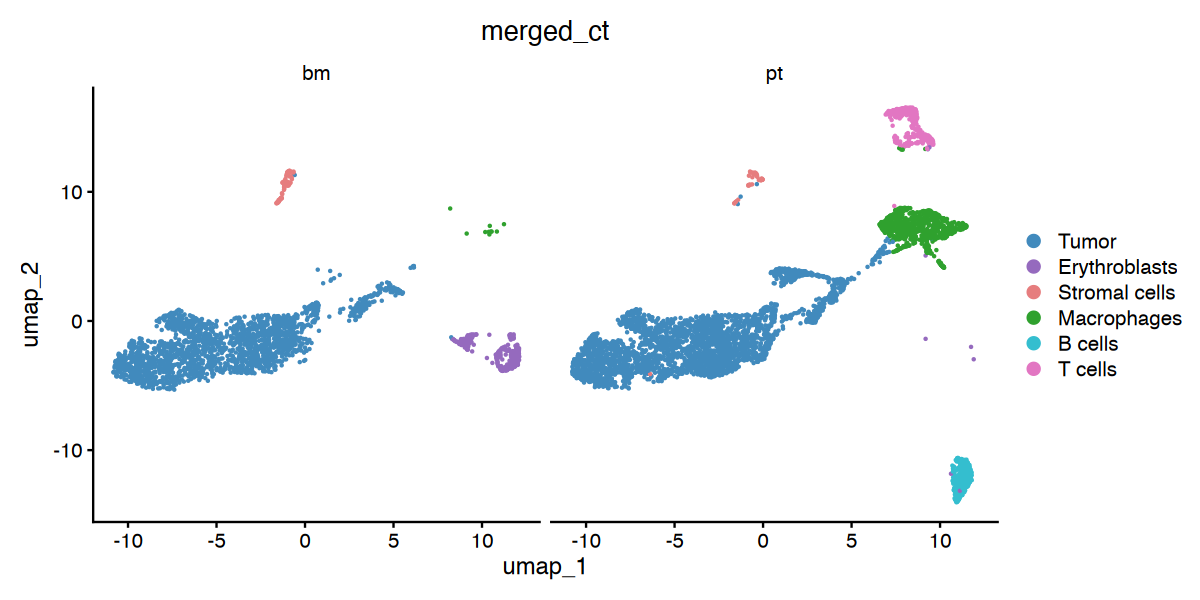

In [9]:
# merge subclusters to major cell types
merged.classes <- as.character(Idents(ptbm.renamed))
for (i in seq(1:length(new.classes))) {
  old.class <- names(new.classes)[i]
  new.class <- new.classes[i]
  merged.classes[merged.classes==old.class] <- new.class
}
ptbm.renamed$merged_ct <- merged.classes
# order cell types
my_levels <-  c("Tumor",
                "Erythroblasts",
                "Stromal cells",
                "Macrophages",
                "B cells",
                 "T cells")
ptbm.renamed$merged_ct <- factor(as.character(ptbm.renamed$merged_ct), 
                                 levels=my_levels)

fig_size(5, 10)
DimPlot(ptbm.renamed, 
        group.by="merged_ct",
        cols=mycolors2,
        split.by = "orig.ident")

## Figure S6

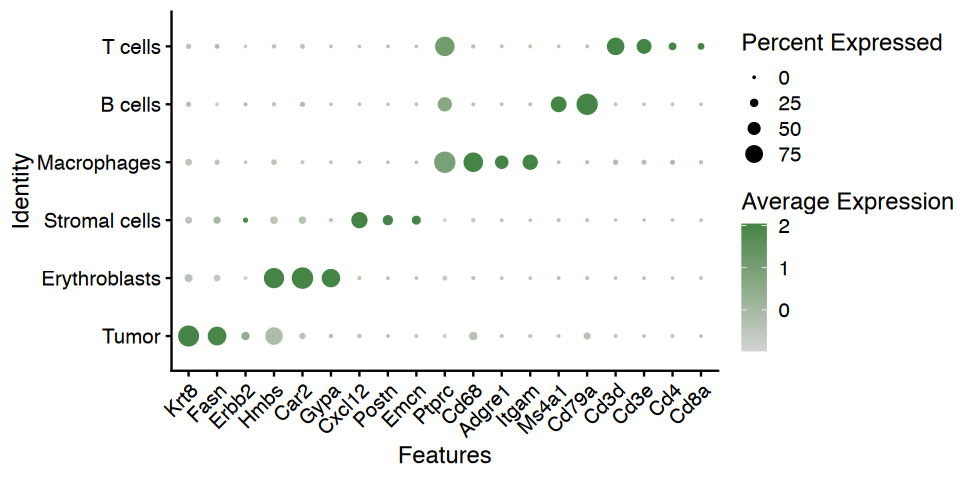

In [13]:
# plot marker genes
DefaultAssay(ptbm.renamed) <- "RNA"
Markergenes = c("Krt8","Fasn","Erbb2",
                "Hmbs",'Car2','Gypa',
                'Cxcl12',"Postn","Emcn",
                "Ptprc",
                'Cd68','Adgre1',"Itgam",
                'Ms4a1','Cd79a',
                'Cd3d','Cd3e',"Cd4","Cd8a")
fig_size(4, 8)
DotPlot(ptbm.renamed, 
        group.by="merged_ct",
        features =Markergenes, 
        dot.scale = 5, 
        cols = c("lightgrey","#448444")) +
RotatedAxis() 

In [14]:
#Subset tumor cluster
Tumor <-subset(x = ptbm.renamed, 
               idents = c("Tumor_a","Tumor_b","Tumor_c","Tumor_d","Tumor_e","Tumor_f"))

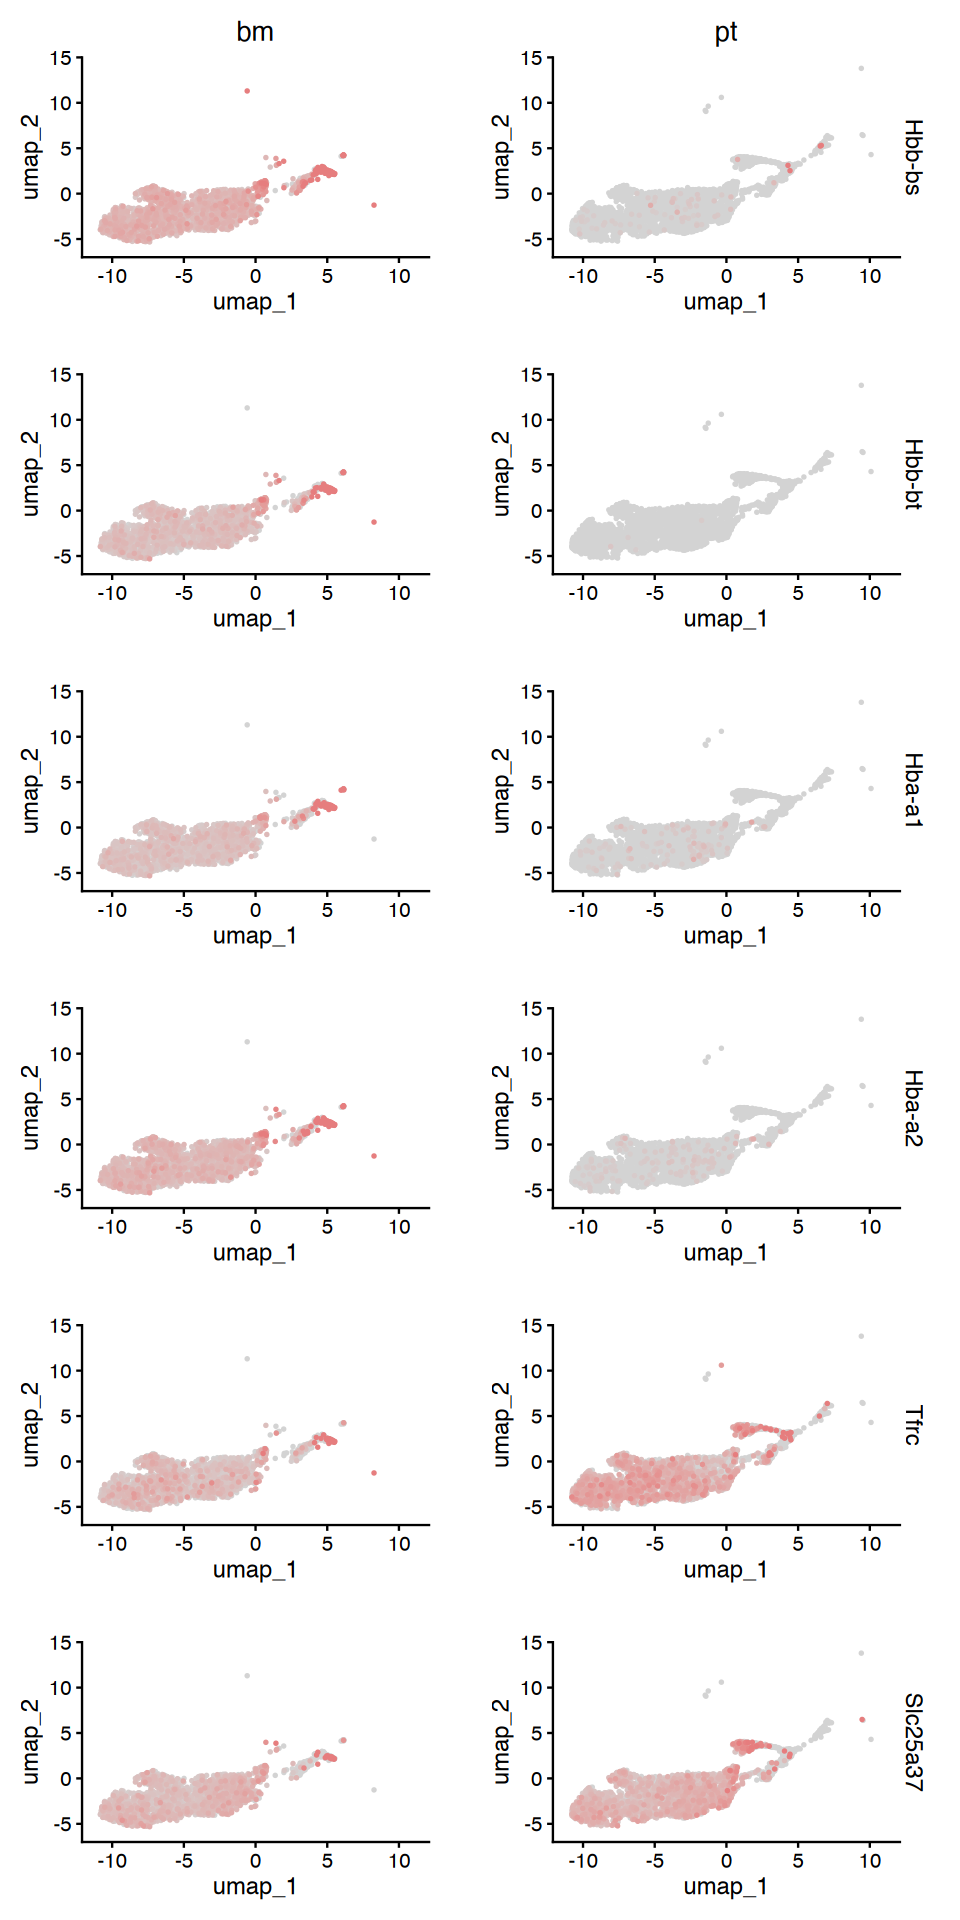

In [15]:
fig_size(16,8)
FeaturePlot(object = Tumor, 
            features = c("Hbb-bs","Hbb-bt","Hba-a1","Hba-a2","Tfrc","Slc25a37"), 
            split.by = "orig.ident", 
            pt.size = 0.5, 
            min.cutoff = 0, 
            max.cutoff = 2, 
            order = T,
            ncol =2,
            cols = c("lightgrey","#E67D7E"))

In [16]:
#filter up-regulated genes in BoneMet tumor
tumor_bm_vs_pt_UP = tumor_bm_vs_pt %>% 
    filter(p_val_adj < 0.05) %>% 
    filter(abs(avg_log2FC) > 0.25)

ERROR: Error in eval(expr, envir, enclos): object 'tumor_bm_vs_pt' not found


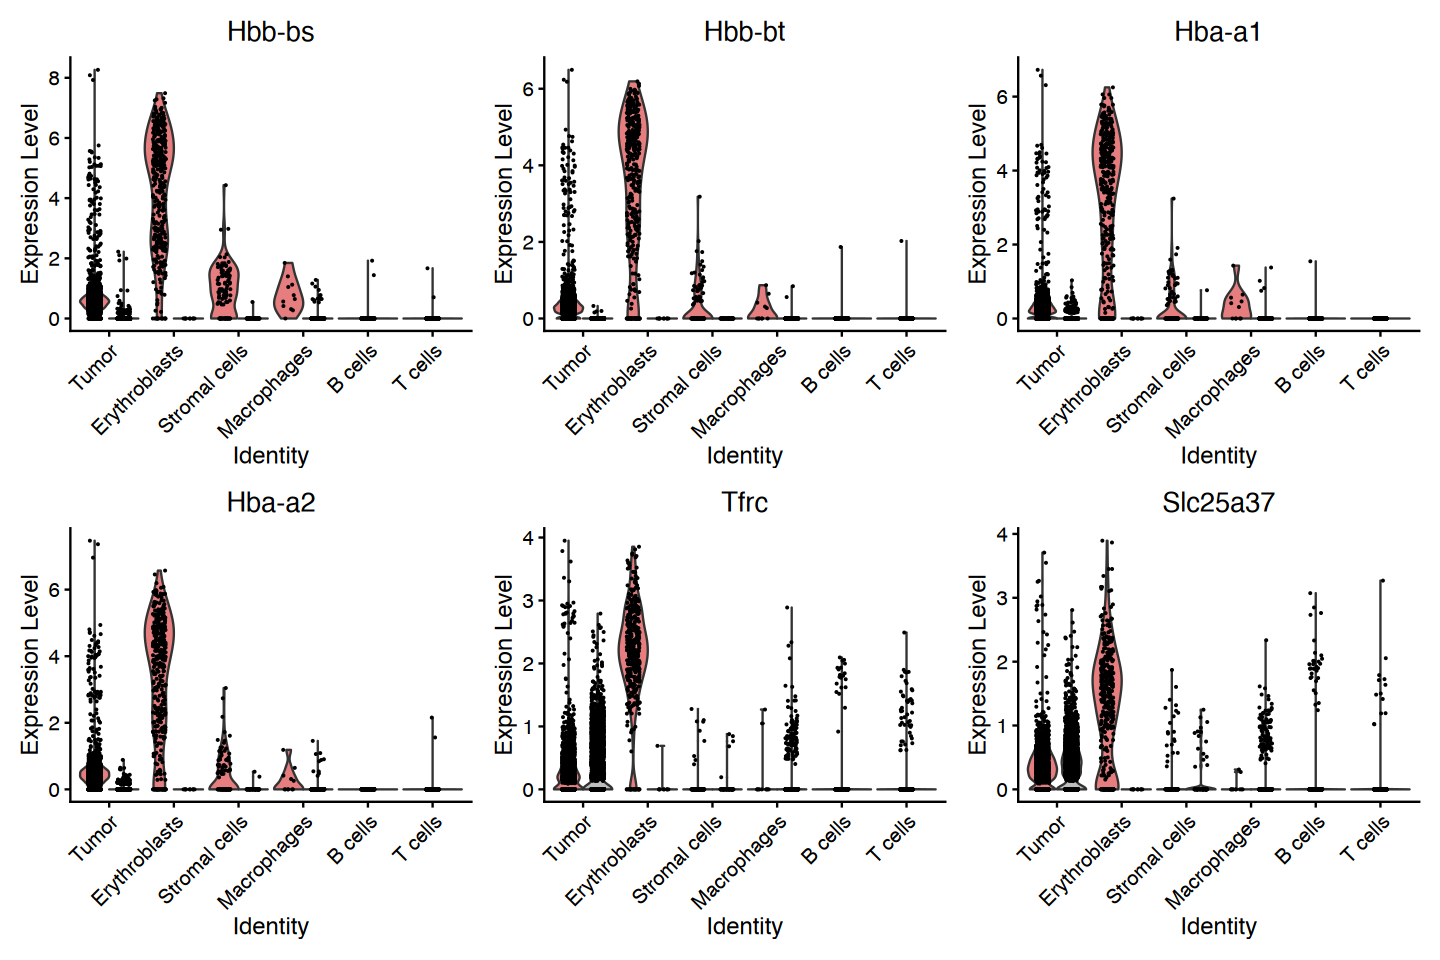

In [23]:
fig_size(8, 12)
VlnPlot(ptbm.renamed, 
        group.by="merged_ct",
        features = c("Hbb-bs","Hbb-bt","Hba-a1","Hba-a2","Tfrc","Slc25a37"), 
        cols=c("#E67D7E","grey"),
        split.by = "orig.ident") 

## Figure 6

In [17]:
# DE analsyis on tumor cells from BoneMet vs Primary site
Tumor$celltype.origident <- paste(Tumor$merged_ct, 
                                  Tumor$orig.ident, sep = "_")
Idents(Tumor) <- "celltype.origident"
tumor_bm_vs_pt<- FindMarkers(Tumor, 
                           ident.1 = "Tumor_bm", 
                           ident.2 = "Tumor_pt",
                           only.pos = TRUE)
tumor_bm_vs_pt_UP = tumor_bm_vs_pt %>% 
    filter(p_val_adj < 0.05) %>% 
    filter(abs(avg_log2FC) > 0.25)

In [18]:
#Hallmark enrichment analysis
msigdb_hm <- read.gmt("/Users/yujiaoh/Princeton Dropbox/Yujiao Han/0-My Dropbox/Manuscript/Yujiao_Manuscript_v4/dataflie/mh.all.v2023.2.Mm.symbols.gmt.txt")
overrep_gene_list <- rownames(tumor_bm_vs_pt_UP)
overrep_msigdb_hm <- enricher(gene = overrep_gene_list, 
                              TERM2GENE = msigdb_hm, 
                              pAdjustMethod = "BH",
                              pvalueCutoff = 0.05)

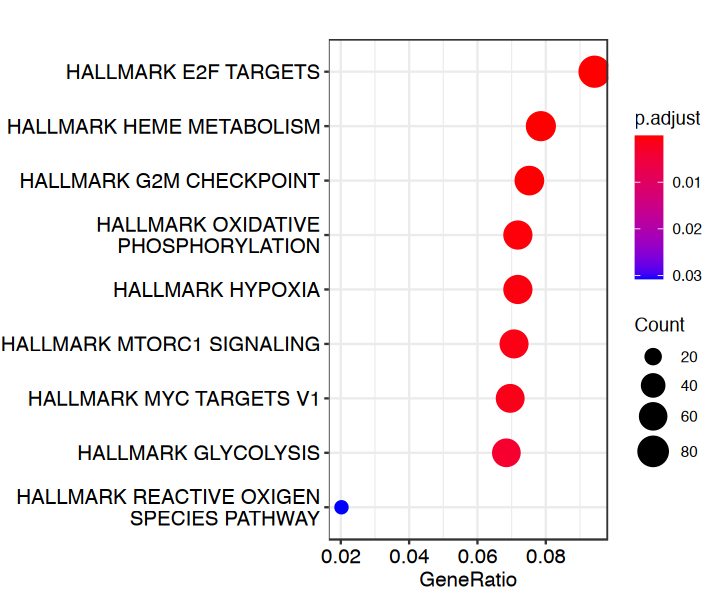

In [19]:
fig_size(5, 6)
dotplot(overrep_msigdb_hm, 
        showCategory = 10)

In [35]:
head (overrep_msigdb_hm)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,84/891,199/4289,1.771488e-12,8.857440e-11,6.526535e-11,Tubb5/Rbbp7/Prdx4/Prps1/Nme1/Rrm2/Suv39h1/Cdkn2c/Smc1a/Mcm4/Dctpp1/Cdc20/Anp32e/Orc2/Mki67/Tk1/Nasp/Lyar/Dck/Hmgb3/Mcm7/Ube2s/Tacc3/Lig1/Pcna/Cdkn3/Cdca8/Wee1/Slbp/Hmgb2/Jpt1/Cks2/Gins1/Birc5/Rfc3/Mcm5/Ung/Xpo1/Pold1/Tbrg4/Tubg1/Mcm3/Cks1b/Brca1/Ccnb2/Chek1/Pop7/Plk4/Srsf2/Rpa2/Bard1/Cenpm/Bub1b/Tmpo/Dut/Dlgap5/Asf1b/Plk1/Mxd3/Racgap1/Aurka/Stmn1/Orc6/Hmmr/Nbn/Kif18b/Mcm6/Chek2/Lmnb1/Dscc1/Msh2/Wdr90/Cdca3/Kif22/Brca2/Aurkb/Gins4/Ccne1/Spc25/Espl1/Usp1/E2f8/Tcf19/Rad51c,84
HALLMARK_HEME_METABOLISM,HALLMARK_HEME_METABOLISM,HALLMARK_HEME_METABOLISM,70/891,188/4289,8.089878e-08,2.022470e-06,1.490241e-06,Car1/Car2/Blvrb/Slc4a1/Mgst3/Ctse/Aldh1l1/Ermap/Rhag/Alad/Prdx2/Sptb/Kel/Fbxo7/Aqp3/Cpox/Tspo2/Cast/Slc25a38/Add2/Ubac1/Lamp2/Rnf19a/Slc22a4/Clcn3/Spta1/Gata1/Optn/Klf1/Cdr2/Lmo2/Alas2/Atg4a/Tcea1/Snca/Ppox/Gclm/Mospd1/Gmps/Ypel5/Riok3/Tal1/Slc2a1/Urod/Rhd/Ranbp10/Eif2ak1/Dcaf11/Epor/Cat/Trak2/Ank1/Abcb6/H1f0/Epb42/Hmbs/Ppp2r5b/Pdzk1ip1/Bpgm/Xk/Ncoa4/Gypc/Mboat2/Fbxo9/Abcg2/Nfe2/Trim10/Dmtn/E2f2/AK157302,70
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,67/891,195/4289,4.501826e-06,7.503044e-05,5.528558e-05,Hspa8/Rasal2/Suv39h1/Cdkn2c/Cdc6/Smc1a/Ube2c/Sap30/Cdc20/Mki67/Ccna2/Gins2/Nasp/Hmgb3/Kpnb1/Ube2s/Tacc3/Cdkn3/Rbl1/Jpt1/Snrpd1/Kif11/Cks2/Birc5/Mcm5/Xpo1/Stil/Mcm3/Cks1b/Cdc45/Ccnb2/Chek1/Plk4/Srsf2/Rpa2/Bard1/Meis1/Tmpo/Rad23b/Bcl3/Sqle/Prc1/Plk1/Pbk/Racgap1/Chaf1a/Aurka/Stmn1/Orc6/Hmmr/Mcm6/Lmnb1/Ythdc1/Smc2/E2f1/Nek2/Kif22/Brca2/Aurkb/Ndc80/Knl1/Espl1/Nusap1/Kif23/Rps6ka5/Rad54l/E2f2,67
HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,64/891,195/4289,3.895769e-05,4.869711e-04,3.588208e-04,Slc25a5/Ndufa1/Hsd17b10/Pdha1/Cox7b/Mgst3/Surf1/Vdac1/Cox5a/Mrpl15/Uqcrc1/Aifm1/Mpc1/Cox5b/Hccs/Atp5k/Atp5g1/Uqcrq/Nqo2/Ndufs8/Vdac3/Cox7a2/Ndufb6/Uqcrb/Pmpca/Idh3a/Bax/Cox11/Uqcr10/Atp5h/Uqcrh/Mrpl34/Echs1/Ogdh/Got2/Ndufab1/Mdh1/Uqcrfs1/Atp5g3/Ndufb8/Prdx3/Ndufb7/Idh1/Dlst/Mrps11/Timm50/Etfdh/Timm8b/Pdp1/Pdhx/Acadm/Ndufv1/Fdx1/Dlat/Mrps22/Fxn/Acadvl/Mrpl11/Ndufa3/Cox17/Oat/Phyh/Atp6v0c/AK157302,64
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,64/891,199/4289,7.802868e-05,7.802868e-04,5.749482e-04,Dcn/Anxa2/Prdx5/Errfi1/Cited2/Aldoc/Hspa5/Mif/Mt1/Serpine1/Galk1/Ccng2/Pgk1/Gcnt2/Btg1/Bhlhe40/Fos/Sap30/Lxn/Fam162a/Tes/Eno3/Ier3/Pgf/Maff/Ppp1r15a/Aldoa/Glrx/Kdelr3/B4galnt2/Efna1/Adm/Col5a1/Csrp2/Ddit4/Pnrc1/Pkp1/Klf6/Jmjd6/Ndrg1/Noct/Eno1b/Jun/Casp6/Slc2a1/Pdk3/Fosl2/Rbpj/Gbe1/Sult2b1/Pygm/Phkg1/Hk1/Bgn/Slc25a1/Vegfa/Stc1/Tktl1/Gpc4/B3galt6/Chst3/S100a4/Isg20/Atf3,64
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,63/891,199/4289,1.483765e-04,1.236471e-03,9.110840e-04,Me1/Ebp/Tuba4a/Hprt/Ppa1/Hspa5/Rrm2/Psmd12/Fkbp2/Pgk1/Polr3g/Atp5g1/Gsr/Sdf2l1/Cacybp/Bhlhe40/Mcm4/Gga2/Tes/Psma4/Ppp1r15a/Aldoa/Uchl5/Idi1/Ufm1/Glrx/Plod2/Dhcr7/Ssr1/Psmb5/Acly/Pno1/Calr/Hspa4/Pnp/Ddit4/Psmd13/Tmem97/Ung/Insig1/Tubg1/Idh1/Nufip1/Xbp1/Rab1a/Rrp9/Eno1b/Tcea1/Psme3/Fads2/Gmps/Sqle/Plk1/Slc2a1/Aurka/Psmg1/Rpn1/Ccng1/Gbe1/Igfbp5/Hmgcs1/Hmbs/Stc1,63


### Data for Fig 6C

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alad,9.221584e-67,1.0034739,0.748,0.476,1.962445e-62
Cpox,3.655678e-47,1.9325061,0.581,0.330,7.779648e-43
Slc25a38,1.163985e-41,0.7903615,0.469,0.245,2.477076e-37
Alas2,2.302492e-28,4.4667087,0.058,0.007,4.899933e-24
Ppox,8.074118e-25,0.7169290,0.341,0.189,1.718253e-20
Urod,1.710263e-21,0.6445970,0.780,0.593,3.639612e-17
Hmox1,5.071774e-20,-0.2820343,0.649,0.461,1.079324e-15
Blvra,2.418559e-17,0.2279158,0.651,0.466,5.146936e-13
Hmbs,5.732905e-16,0.6078124,0.828,0.678,1.220019e-11


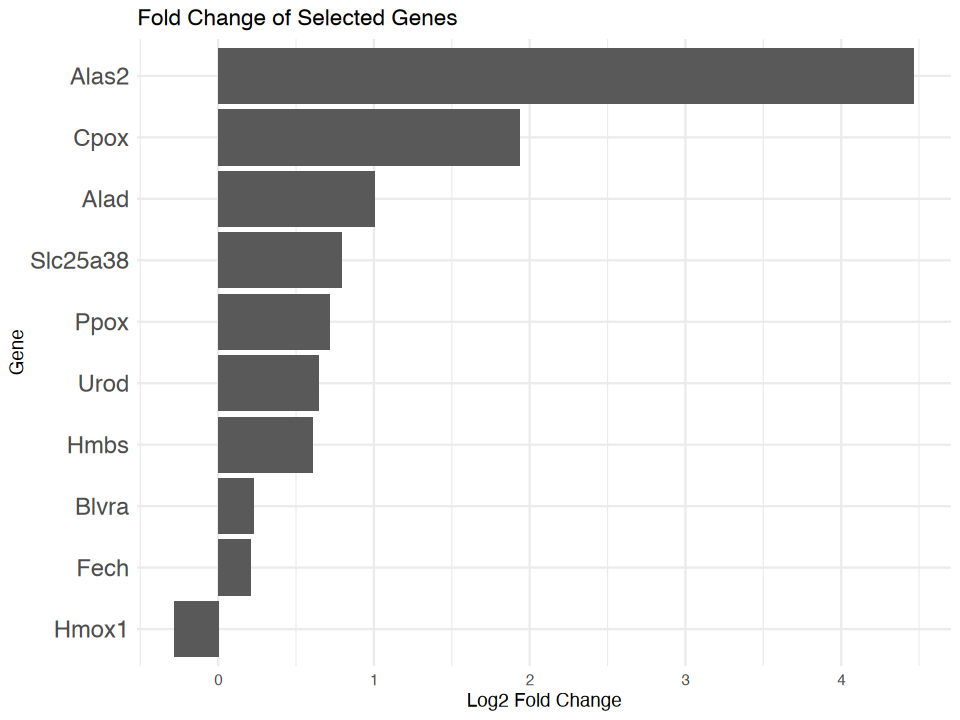

In [38]:
# Heme synthesis and heme catabolism gene expression
fig_size(4, 10)
Tumor$celltype.origident <- paste(Tumor$merged_ct, 
                                  Tumor$orig.ident, sep = "_")
Idents(Tumor) <- "celltype.origident"
tumorgenes<- FindMarkers(Tumor, 
                           ident.1 = "Tumor_bm", 
                           ident.2 = "Tumor_pt")

heme_metabolism <- c("Slc25a38","Alas2","Alad", "Hmbs", "Uros","Urod","Cpox","Ppox", "Fech","Hmox1", "Blvra")
selected_markers <- tumorgenes[rownames(tumorgenes) %in% heme_metabolism, ]

fig_size(6,8)
ggplot(selected_markers, aes(x = reorder(rownames(selected_markers), avg_log2FC), y = avg_log2FC)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(x = "Gene", y = "Log2 Fold Change", title = "Fold Change of Selected Genes") +
  theme_minimal()+
  theme(axis.text.y = element_text(size = 14))

selected_markers

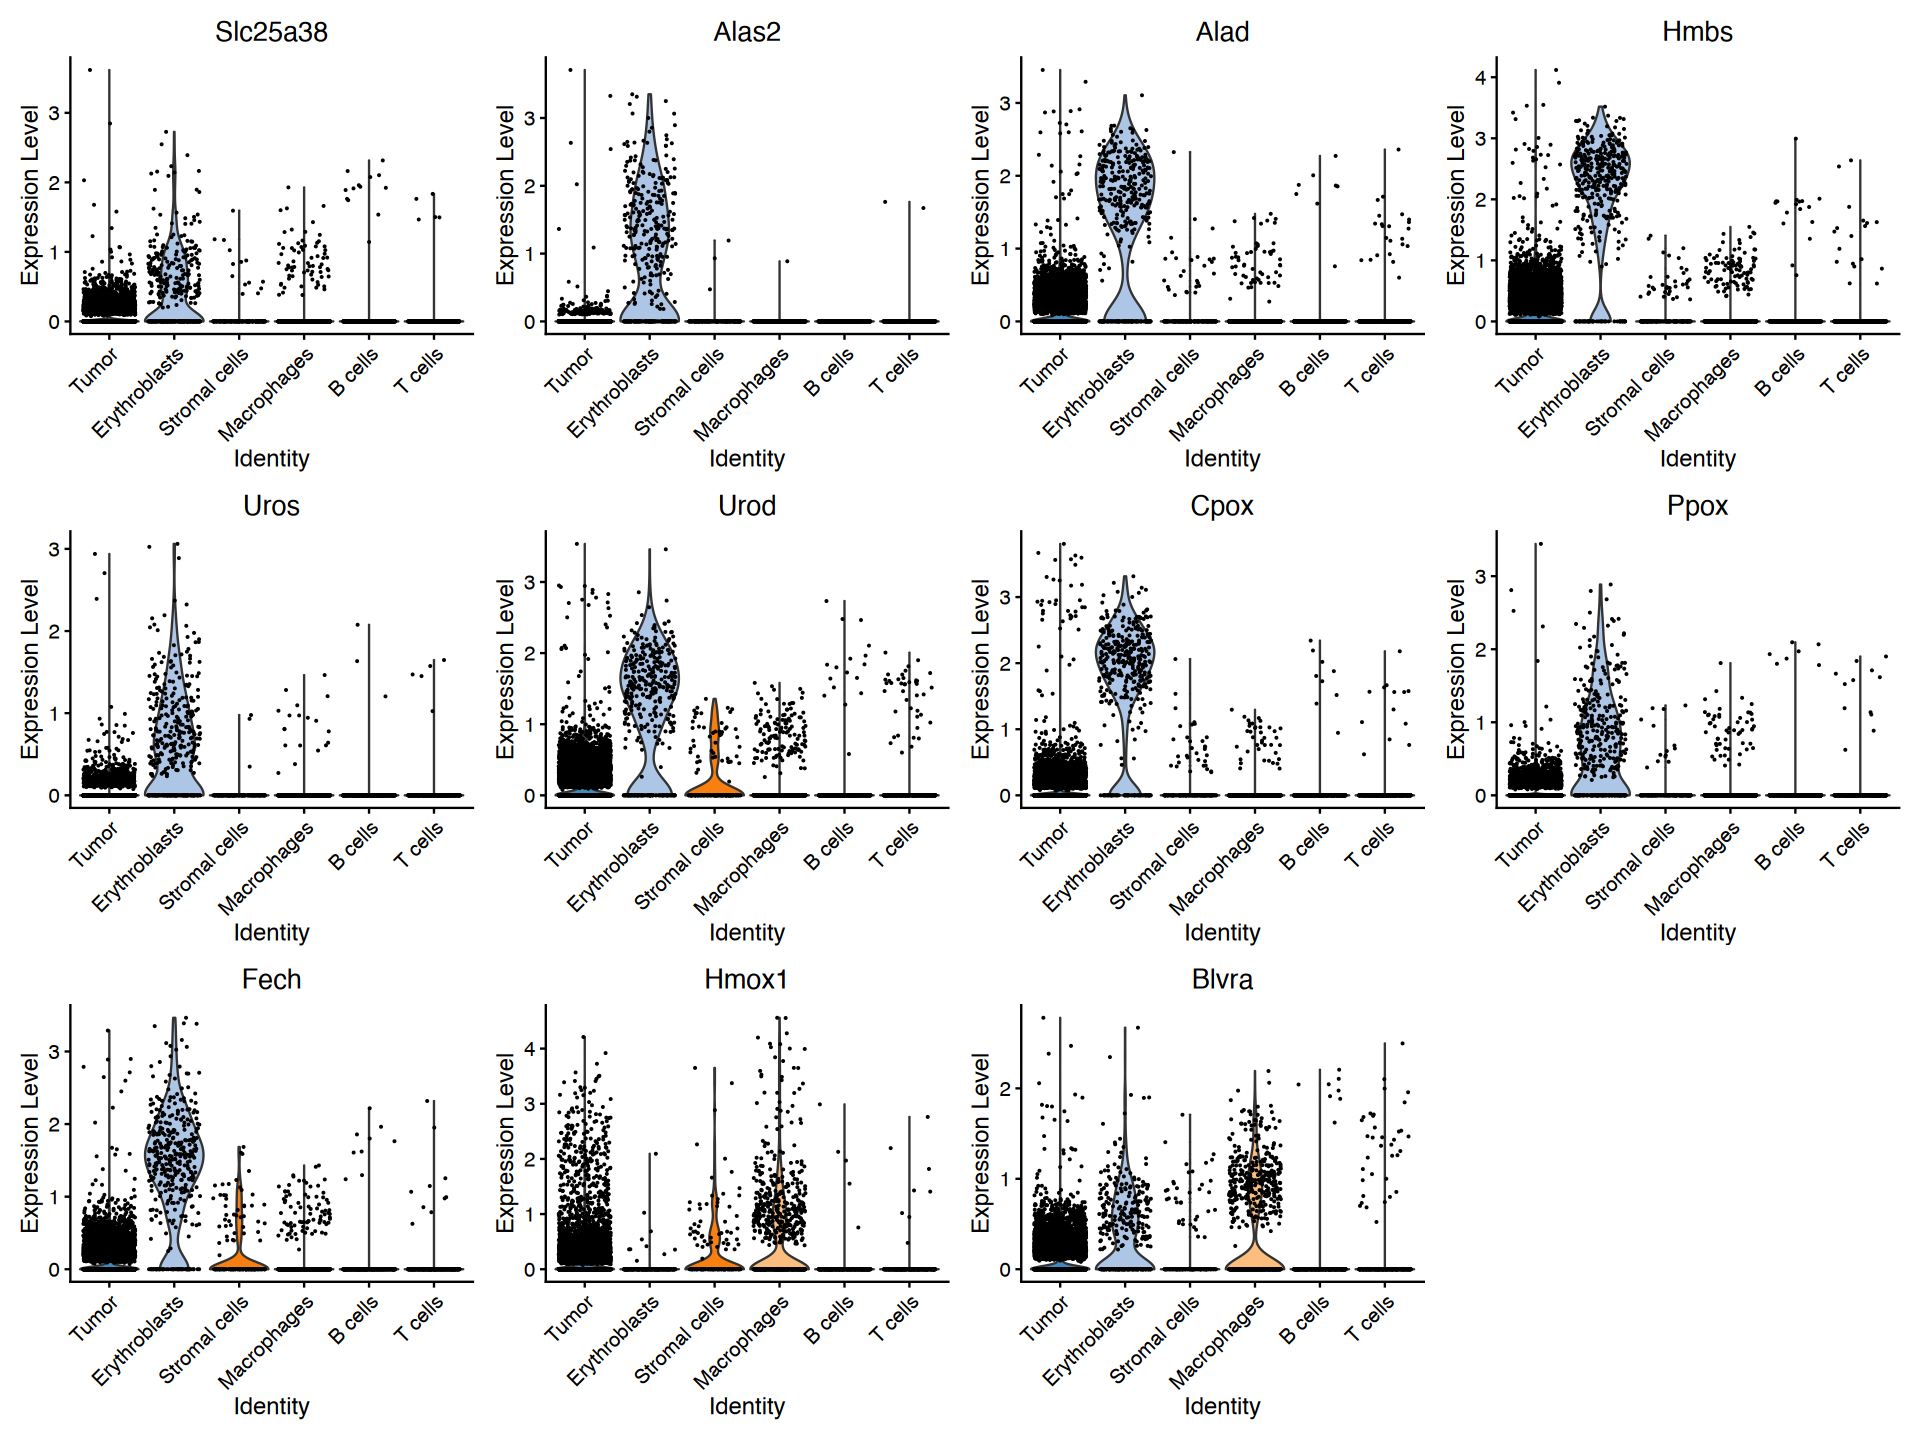

In [28]:
fig_size(12, 16)
VlnPlot(ptbm.renamed, 
        group.by="merged_ct",
        features = c("Slc25a38","Alas2","Alad", "Hmbs", "Uros","Urod","Cpox","Ppox", "Fech","Hmox1", "Blvra"), 
        cols=mycolors) 